In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', period='max', interval='1d')
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,21788.203125,17821046406
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,21808.101562,23918742607
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,22220.804688,26792596581


In [3]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop([ 'Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2976 entries, 2014-12-25 to 2023-02-18
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2976 non-null   float64
 1   High       2976 non-null   float64
 2   Low        2976 non-null   float64
 3   Adj Close  2976 non-null   float64
 4   Volume     2976 non-null   int64  
 5   RSI        2976 non-null   float64
 6   EMA_short  2976 non-null   float64
 7   EMA_long   2976 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 209.2 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-07,22757.267578,23310.974609,22756.257812,23264.291016,27187964471,64.484885,22542.069704,19903.181588
2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,25371367758,60.306257,22579.910536,19963.304694
2023-02-09,22946.566406,22996.437500,21773.974609,21819.039062,32572572185,48.656922,22507.446586,20000.051909
2023-02-10,21819.005859,21941.185547,21539.392578,21651.183594,27078406594,47.193524,22425.897730,20032.747586
2023-02-11,21651.841797,21891.410156,21618.449219,21870.875000,16356226232,49.330527,22373.038422,20069.146149
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,17821046406,48.538550,22317.339823,20103.186881
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,23918742607,48.750732,22268.840941,20136.947568
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,26792596581,53.052268,22264.266059,20178.212065
2023-02-15,22220.585938,24307.841797,22082.769531,24307.841797,32483312909,67.728410,22458.892320,20259.986911


In [4]:
# Split data into training and testing sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

In [5]:
train_x = train_data.index
train_y = train_data['Adj Close']
test_x = test_data.index
test_y = test_data['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='Train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title ='Train and Test Bitcoin Data',
    font_size=15,
    font_color='black',
    legend_title_text=' Parameters'
)

fig.show()

In [6]:
print ('Train shape',train_data.shape)
print ('test shape', test_data.shape)

Train shape (2480, 8)
test shape (496, 8)


In [ ]:
# Normalize the data
"""mean = train_data.mean()
std = train_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std"""


In [8]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(5, train_data.shape[1]), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            43600     
                                                                 
 dropout (Dropout)           (None, 5, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 75)             52800     
                                                                 
 dropout_2 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [9]:
# Prepare the training data
X_train = np.array([train_data[i:i+5] for i in range(len(train_data)-5)])
y_train = np.array([train_data.iloc[i+5] for i in range(len(train_data)-5)])
# Prepare the testing data 
X_test = np.array([test_data[i:i+5] for i in range(len(test_data)-5)])
y_test = np.array([test_data.iloc[i+5] for i in range(len(test_data)-5)])

In [10]:
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape) 

X_train (2475, 5, 8)
y_train (2475, 8)
X_test (491, 5, 8)
Y_test (491, 8)


In [13]:
# Reshape the input data to 2 dimensions
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_test_2d = X_test.reshape(-1, X_test.shape[-1])

In [14]:

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)
#y_train = y_train.reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
#y_test = y_test.reshape(-1, 1)
y_test = scaler.fit_transform(y_test)


# Reshape the scaled data back to 3 dimensions
X_train = X_train_scaled.reshape(X_train.shape)
X_test = X_test_scaled.reshape(X_test.shape)

In [15]:
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape) 

X_train (2475, 5, 8)
y_train (2475, 8)
X_test (491, 5, 8)
Y_test (491, 8)


In [16]:
# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=250, batch_size=32)

Epoch 1/250
78/78 [==============================] - 17s 33ms/step - loss: 0.0365 - accuracy: 0.8812 - mean_absolute_error: 0.1173
Epoch 2/250
78/78 [==============================] - 3s 33ms/step - loss: 0.0106 - accuracy: 0.8937 - mean_absolute_error: 0.0684
Epoch 3/250
78/78 [==============================] - 3s 33ms/step - loss: 0.0077 - accuracy: 0.9010 - mean_absolute_error: 0.0571
Epoch 4/250
78/78 [==============================] - 3s 34ms/step - loss: 0.0067 - accuracy: 0.9083 - mean_absolute_error: 0.0521
Epoch 5/250
78/78 [==============================] - 3s 36ms/step - loss: 0.0062 - accuracy: 0.9095 - mean_absolute_error: 0.0489
Epoch 6/250
78/78 [==============================] - 3s 43ms/step - loss: 0.0058 - accuracy: 0.9152 - mean_absolute_error: 0.0474
Epoch 7/250
78/78 [==============================] - 3s 34ms/step - loss: 0.0052 - accuracy: 0.9204 - mean_absolute_error: 0.0442
Epoch 8/250
78/78 [==============================] - 3s 36ms/step - loss: 0.0050 - accura

In [17]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16,5))
 
    plt.plot(history['mean_absolute_error'])
    plt.legend([ 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16,5))
 
    plt.plot(history['loss'])
    plt.legend([ 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))

    plt.plot(history['accuracy'])
    plt.legend([ 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()




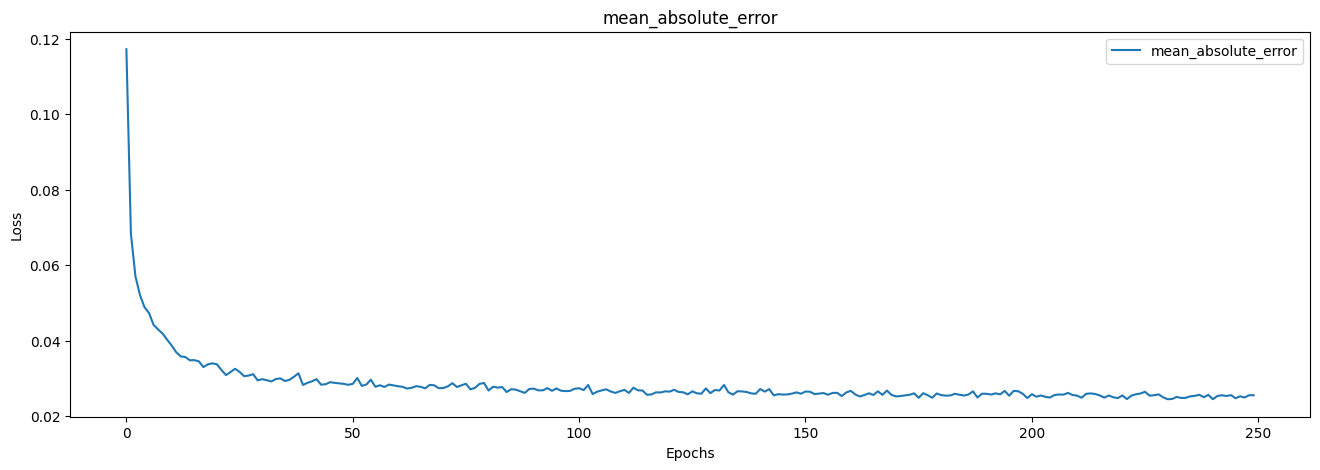

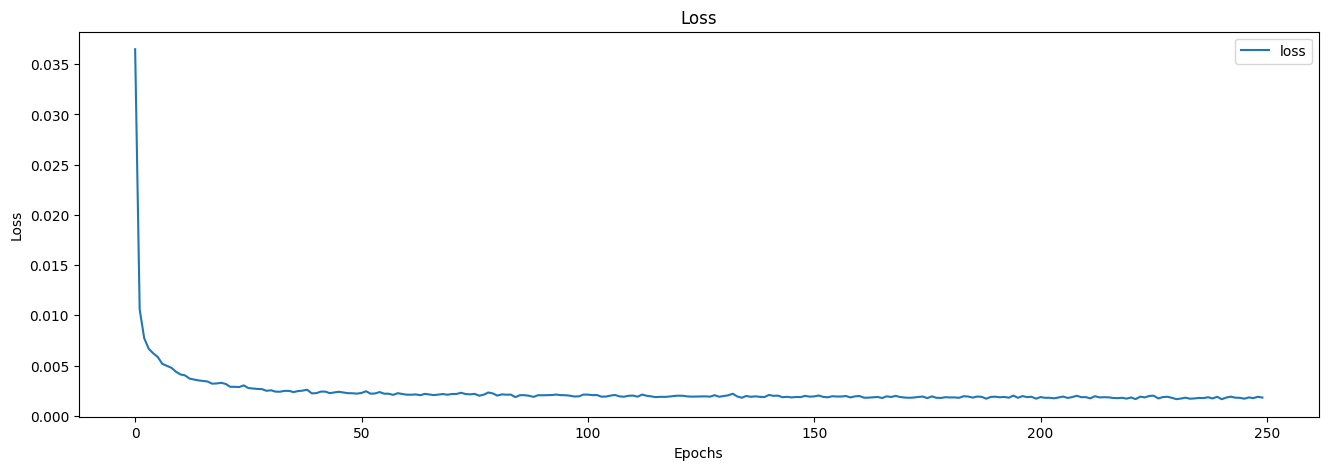

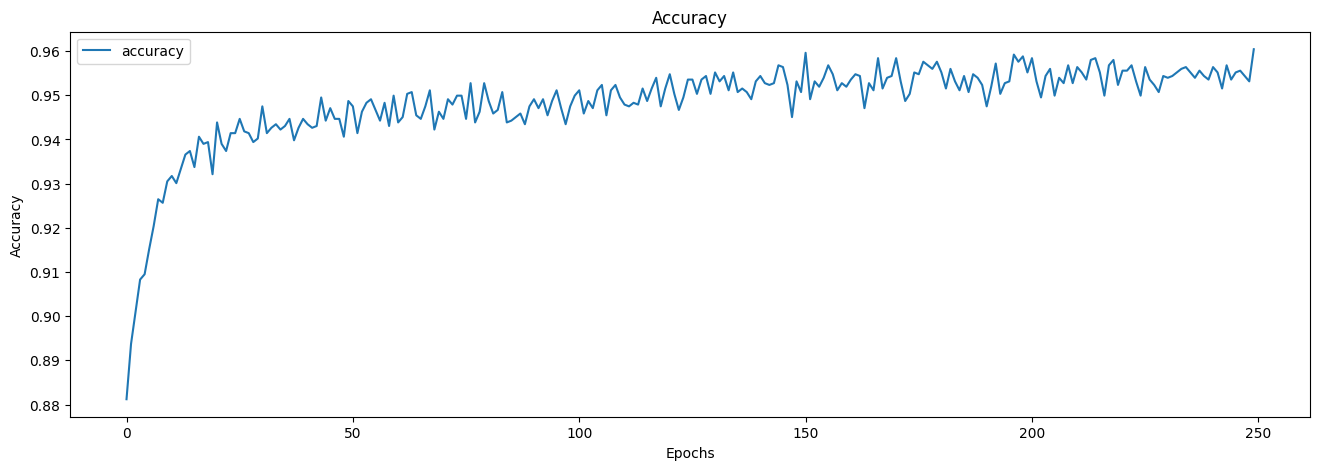

In [18]:
visualize_training_results(history)

In [19]:
mean_squared_error,accuracy ,mean_absolute_error = model.evaluate(X_test, y_test)


16/16 [==============================] - 2s 13ms/step - loss: 0.0319 - accuracy: 0.7393 - mean_absolute_error: 0.1501


In [20]:
# Make predictions on the test data
y_pred = model.predict(X_test)

16/16 [==============================] - 1s 10ms/step


In [21]:
print('y_pred',y_pred.shape)
print('y_test',y_test.shape)

y_pred (491, 8)
y_test (491, 8)


In [22]:
# convert to original data 
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [24]:
print (y_pred)
print ('-------------------------------------------------------------')
print (y_test)


[[5.8113488e+04 5.9383617e+04 5.6641320e+04 ... 5.9987217e+01
  5.5364113e+04 5.0214281e+04]
 [5.8444793e+04 5.9728051e+04 5.6944586e+04 ... 5.9571678e+01
  5.5737891e+04 5.0389832e+04]
 [5.9650633e+04 6.0950035e+04 5.8118875e+04 ... 6.0604656e+01
  5.6571645e+04 5.0511535e+04]
 ...
 [3.1282311e+04 3.2043004e+04 3.0604430e+04 ... 5.0778477e+01
  3.2223027e+04 3.3310602e+04]
 [3.1899992e+04 3.2655549e+04 3.1260254e+04 ... 5.3021835e+01
  3.2383783e+04 3.3459160e+04]
 [3.4820477e+04 3.5682465e+04 3.4138148e+04 ... 6.6026253e+01
  3.3635559e+04 3.3111992e+04]]
-------------------------------------------------------------
[[5.73728320e+04 5.84787344e+04 5.69570742e+04 ... 6.76931314e+01
  5.19701365e+04 4.60950927e+04]
 [5.73459023e+04 6.27571289e+04 5.68681445e+04 ... 7.35912794e+01
  5.28866901e+04 4.64020007e+04]
 [6.16095273e+04 6.22744766e+04 6.02061211e+04 ... 7.13004320e+01
  5.36491177e+04 4.66889350e+04]
 ...
 [2.18018223e+04 2.22931406e+04 2.16323945e+04 ... 5.30522680e+01
  2.22

In [25]:
# Compute the evaluation metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = np.mean((y_test - y_pred)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))

print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MAPE: 32.58%
MSE: 37891019722219634688.00
RMSE: 6155568188.41
MAE: 1640098223.15


In [26]:
# Calculate the MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("MAPE:", mape)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE:", rmse)

# Calculate the MSE (Mean Squared Error)
mse = np.mean((y_test - y_pred) ** 2)
print("MSE:", mse)

# Calculate the MAE (Mean Absolute Error)
mae = np.mean(np.abs(y_test- y_pred))
print("MAE:", mae)


MAPE: 32.581725779820765
RMSE: 6155568188.414424
MSE: 3.7891019722219635e+19
MAE: 1640098223.1463373


In [ ]:
print( X_test.shape)

In [27]:

# Use the model to predict the next 10 days of Bitcoin prices
last_five_days = np.array([test_data.iloc[-30:].values])
predictions = []
for i in range(10):
    prediction = model.predict(last_five_days)[0]
    predictions.append(prediction)
    last_five_days = np.append(last_five_days[:,1:,:],  [prediction[np.newaxis,:]], axis=1)


1/1 [==============================] - 0s 62ms/step


In [ ]:
# Convert the predictions back to actual Bitcoin prices
predictions = np.array(predictions) * std.values + mean.values


In [ ]:
test_data= np.array(test_data) * std.values + mean.values

test_data

In [ ]:
predictions.shape


In [ ]:
# Create a new dataframe for predictions
preds_df = pd.DataFrame(predictions, columns=['Open','High','Low','Adj Close','Volume','RSI','EMA_short','EMA_long'], index=pd.date_range(start=test_data.index[-1], periods=10, freq="D"))

# Create a new dataframe for last five days
last_five_days_df = pd.DataFrame(last_five_days[0], columns=test_data.columns, index=pd.date_range(start=test_data.index[-30], periods=30, freq="D"))


preds_df

In [ ]:
last_five_days_df

In [ ]:

# Combine the two dataframes and plot the results
combined_df = pd.concat([test_data, preds_df])
plt.figure(figsize=(16,5))
plt.plot(combined_df["Adj Close"], label="Actual")
plt.plot(combined_df["Adj Close"].iloc[-10:], label="Predicted")
plt.legend()
plt.show()
